In [147]:
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Les modules nécessaires externes
# ------------------------------------------------------------------------------------------------------------------------------------------------

import os
import requests
import sys
import gzip

import datetime
import time





import pandas as pd
import numpy as np



# matplotlib
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


# ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace import sarimax

# Métriques 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Décomposition série temporelle

from statsmodels.tsa.seasonal import seasonal_decompose 



 # Tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM


# split data
from sklearn.model_selection import train_test_split

#Pipeline
 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer


# Normalisation
from sklearn import preprocessing


#Gestion de la mémoire
import gc



# Métriques 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [148]:
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Les modules nécessaires developpés
# ------------------------------------------------------------------------------------------------------------------------------------------------

import decomposition_serie_temporelle
import analyse_spectrale 
import pipeline_analyse_spectrale_decomposition 
import analyse_et_sarima
import sarimax_model
import lstm_model
import sequence_transformer
import inversion_transformer
import normalisation_transformation
import wrapper_pour_lstm
import realigner
# pour la mise à jour
import importlib
importlib.reload(decomposition_serie_temporelle)
importlib.reload(analyse_spectrale)
importlib.reload(pipeline_analyse_spectrale_decomposition)
importlib.reload(lstm_model)
importlib.reload(sarimax_model)
importlib.reload(analyse_et_sarima)
importlib.reload(sequence_transformer)
importlib.reload(inversion_transformer)
importlib.reload(normalisation_transformation)
importlib.reload(wrapper_pour_lstm)
importlib.reload(realigner)

from decomposition_serie_temporelle import DecompositionSerieTemporelle
from analyse_spectrale import SpectrogramAnalysis
from sarimax_model import SARIMAModel
from lstm_model import LSTMModel
from pipeline_analyse_spectrale_decomposition import SpectroDecompPipeline
from analyse_et_sarima import SpectrogramToSARIMAPipeline
from sequence_transformer import SequenceTransformer
from inversion_transformer import InversionTransformer
from normalisation_transformation import NormalisationTransformer
from wrapper_pour_lstm import WrapperforLSTM
from realigner import ReAligner 
 


In [149]:
# nettoyage
from tensorflow.keras import backend as K
K.clear_session()
gc.collect()
#del df, df_1, df_1_decomposed

0

In [150]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

reg = 0
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)


In [151]:
LISTE_PROFILE = list(['RES1 (+ RES1WE)', 'RES11 (+ RES11WE)', 'RES2 (+ RES5)', 'RES2WE','RES3', 'RES4'])
liste_profile = list(set(df['Profil'].unique()) & set(LISTE_PROFILE)) # liste des profiles
cp = 0
for profile in df['Profil'].unique():
    cp = cp + len(df.loc[(df['Profil']==profile)]['Plage de puissance souscrite'].unique())
cp

73

In [152]:
df['Profil'].unique()

array(['ENT3 (+ ENT4 + ENT5)', 'PRO1 (+ PRO1WE)',
       'PRO2 (+ PRO2WE + PRO6)', 'PRO3', 'PRO4', 'PRO5',
       'RES1 (+ RES1WE)', 'RES11 (+ RES11WE)', 'RES2 (+ RES5)', 'RES2WE',
       'RES3', 'RES4'], dtype=object)

In [157]:
df.loc[(df['Profil']=='RES11 (+ RES11WE)')]['Plage de puissance souscrite'].unique()

array(['P0: Total <= 36 kVA', 'P3: ]6-9] kVA', 'P4: ]9-12] kVA',
       'P5: ]12-15] kVA', 'P6: ]15-18] kVA', 'P7: ]18-24] kVA',
       'P8: ]24-30] kVA', 'P9: ]30-36] kVA'], dtype=object)

In [158]:
# Selection d'un profile et puissance

df_1 = df.loc[((df['Profil']=='RES11 (+ RES11WE)')) & (df['Plage de puissance souscrite']=='P4: ]9-12] kVA')].iloc[0:365*48]


In [123]:
# division par le nombre de points de soputirage
df_1['Total énergie soutirée (Wh)'] = df_1['Total énergie soutirée (Wh)']/df_1['Nb points soutirage'] #np.log(df_1['Total énergie soutirée (Wh)'])


In [124]:
df_1.head()

,Région,Code région,Profil,Plage de puissance souscrite,Nb points soutirage,Total énergie soutirée (Wh),Courbe Moyenne n°1 (Wh),Indice représentativité Courbe n°1 (%),Courbe Moyenne n°2 (Wh),Indice représentativité Courbe n°2 (%),...,date,year,month,month_n,day,day_n,h,mn,s,Rayonnement solaire global (W/m2)
0,Auvergne-Rhône-Alpes,84.0,ENT3 (+ ENT4 + ENT5),P0: Total <= 36 kVA,1374.0,1514.89083,1734.0,49,1264.0,48,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,0.0,0.0,0.0,0.0
1,Auvergne-Rhône-Alpes,84.0,ENT3 (+ ENT4 + ENT5),P0: Total <= 36 kVA,1374.0,1514.89083,1734.0,49,1264.0,48,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,0.0,30.0,0.0,0.0
2,Auvergne-Rhône-Alpes,84.0,ENT3 (+ ENT4 + ENT5),P0: Total <= 36 kVA,1374.0,1514.89083,1734.0,49,1264.0,48,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,1.0,0.0,0.0,0.0
3,Auvergne-Rhône-Alpes,84.0,ENT3 (+ ENT4 + ENT5),P0: Total <= 36 kVA,1374.0,1514.89083,1734.0,49,1264.0,48,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,1.0,30.0,0.0,0.0
4,Auvergne-Rhône-Alpes,84.0,ENT3 (+ ENT4 + ENT5),P0: Total <= 36 kVA,1374.0,1514.89083,1734.0,49,1264.0,48,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,2.0,0.0,0.0,0.0


In [159]:
# gestion des nan
def imputer_series(s, method='ffill', window=3):
    """
    Impute les valeurs manquantes d'une série temporelle.

    Parameters
    ----------
    s : pd.Series
        Série temporelle avec un DatetimeIndex.
    method : str
        Méthode d'imputation : 'interpolate', 'ffill', 'bfill', 'rolling'.
    window : int
        Taille de la fenêtre pour la moyenne glissante (si method='rolling').

    Returns
    -------
    s_filled : pd.Series
        Série avec trous imputés.
    """
    s = s.sort_index()

    if method == 'ffill':
        return s.ffill()
    elif method == 'bfill':
        return s.bfill()
    elif method == 'rolling':
        return s.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    else:
        raise ValueError("Méthode d'imputation non reconnue : utilisez 'interpolate', 'ffill', 'bfill' ou 'rolling'.")
# Pour régler certaines irrégularité dans les données vues en tant que séries temporelles
def force_datetime_index(df, freq='30min', start_default = '2023-01-01'):
    """
    Force un DataFrame à avoir un DatetimeIndex régulier.

    Parameters
    ----------
    df : pd.DataFrame ou pd.Series
        Données d'entrée sans index temporel.
    freq : str
        Fréquence du pas temporel (ex : '30min', '1H').
    start_time : str or pd.Timestamp
        Date de départ pour créer l'index.

    Returns
    -------
    df_copy : pd.DataFrame or pd.Series
        Données avec un DatetimeIndex régulier.
    """
    h_str = df['h'].astype(int).astype(str).str.zfill(2)
    mn_str = df['mn'].astype(int).astype(str).str.zfill(2)

    date = pd.to_datetime(df['date'] + ' ' + h_str + ':' + mn_str, format='%Y-%m-%d %H:%M')
    #date = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))
    
    if df['date'].min() is pd.NaT:
        start_time = date.min() or start_default
    else:
        start_time = start_default

    df_copy = df.copy()
    new_index = pd.date_range(start=start_time, periods=len(df_copy), freq=freq)
    df_copy.index = new_index
    return df_copy
df_1 = force_datetime_index(df_1)
df_1 = imputer_series(df_1, method='ffill', window=3)

In [160]:
df_1.head()

,Région,Code région,Profil,Plage de puissance souscrite,Nb points soutirage,Total énergie soutirée (Wh),Courbe Moyenne n°1 (Wh),Indice représentativité Courbe n°1 (%),Courbe Moyenne n°2 (Wh),Indice représentativité Courbe n°2 (%),...,date,year,month,month_n,day,day_n,h,mn,s,Rayonnement solaire global (W/m2)
2023-01-01 00:00:00,Auvergne-Rhône-Alpes,84.0,RES11 (+ RES11WE),P4: ]9-12] kVA,121948.0,45436683.0,534.0,8,351.0,7,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,0.0,0.0,0.0,0.0
2023-01-01 00:30:00,Auvergne-Rhône-Alpes,84.0,RES11 (+ RES11WE),P4: ]9-12] kVA,121948.0,46803936.0,548.0,8,360.0,7,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,0.0,30.0,0.0,0.0
2023-01-01 01:00:00,Auvergne-Rhône-Alpes,84.0,RES11 (+ RES11WE),P4: ]9-12] kVA,121948.0,43017564.0,534.0,8,338.0,7,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,1.0,0.0,0.0,0.0
2023-01-01 01:30:00,Auvergne-Rhône-Alpes,84.0,RES11 (+ RES11WE),P4: ]9-12] kVA,121948.0,44281304.0,541.0,8,346.0,7,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,1.0,30.0,0.0,0.0
2023-01-01 02:00:00,Auvergne-Rhône-Alpes,84.0,RES11 (+ RES11WE),P4: ]9-12] kVA,121948.0,41835052.0,521.0,8,327.0,7,...,2023-01-01,2023.0,1.0,January,1.0,Sunday,2.0,0.0,0.0,0.0


In [175]:
#df_test = pd.read_csv('test.csv', index_col=0)

spectro_params_default ={"fs": 1/1800, # Fréquence d'échantillonnage (1 point chaque 1800 secondes
                         "window": "hann",         # Fenêtre de Hann
                         "nperseg": 30*48,         # Longueur de la fenêtre d'analyse spectrale
                         "noverlap": 24,           # Recouvrement entre fenêtres
                         "threshold": 0.2   # Seuil de detection
                        } 
#test
#spectrodecomp = SpectroDecompPipeline(target_column='Total énergie soutirée (Wh)', spectro_kwargs=spectro_params_default)
#spectrodecomp.fit(df_1)
#df_t = spectrodecomp.transform(df_1)


def premiere_analyse(df,spectro_params = None, column_target = None):
        column_target = column_target or 'y'
        spectro_params = spectro_params or spectro_params_default
        spectrogram_analyzer = SpectrogramAnalysis(**spectro_params) 
        y = df[column_target]
        spectrogram_analyzer.fit(y)
        df_retour = spectrogram_analyzer.transform(y) 

        #spectrogram_analyzer.plot_spectrogramme()
        #periodes = spectrogram_analyzer.transform(y) 
        #return periodes
        return spectrogram_analyzer.dominant_periodes.astype(int).tolist()[0:2]
        #return periodes.values.flatten()

"""
for file_name in liste_file:  # boucle séquentielle sur les régions
        file = os.path.join(folder_BD_propre, file_name)
        df = pd.read_csv(file, low_memory=False)
        reg = df['Région'].unique()[0]
        print("Nous traitons la région ....", reg)
        
        for profile in df['Profil'].unique():
                for puissance in df.loc[df['Profil']==profile]['Plage de puissance souscrite'].unique():
                        
                        df_profile_puissance = df.loc[(df['Profil']==profile) & (df['Plage de puissance souscrite']==puissance)]  # extraction de la partie de la base

                        df_1 = force_datetime_index(df_profile_puissance, freq='30min')
                        df_2 = imputer_series(df_1, method='ffill', window=3)
               
                        df_2['Total énergie soutirée (Wh)'] = df_2['Total énergie soutirée (Wh)']/df_2['Nb points soutirage']
                        #periodes =  premiere_analyse(df_2,spectro_params_default,column_target = 'Total énergie soutirée (Wh)')
                        periodes =  premiere_analyse(df_2,spectro_params_default,column_target = 'Total énergie soutirée (Wh)')
                        periodes = np.array(list(set(periodes) & set([11,14,15,22,44])))
                        if (len(periodes) == 0):
                                periodes = [44]

                        # Générer dynamiquement les noms de colonnes
                        columns = [f'P_{i+1}' for i in range(len(periodes))]
                        # Convertir en DataFrame
                        periodes_val = pd.DataFrame([periodes], columns=columns
                        df_periodes = pd.DataFrame({'region' : [reg], 
                             'Profil' : [profile],
                             'Puissance' : [puissance] })

                        df_periodes = pd.concat([df_periodes, periodes_val], axis=0)
                        df_periodes.to_csv('periodes.csv', mode='a', header=not os.path.exists('periodes.csv'), index=False)"""


        
periodes =  premiere_analyse(df_1,spectro_params_default,column_target = 'Total énergie soutirée (Wh)')
#periodes = np.array(list(set(periodes) & set([11,14,15,22,44])))
#if (len(periodes) == 0):
#        periodes = [44]

In [176]:
periodes

[22, 44]

In [163]:
# pipeline 1
L =['Total énergie soutirée (Wh)', 'T_moyenne', 'U_moyenne', 'Rayonnement solaire global (W/m2)']
analyse_decomposition_columns = {}

#["multiplicative","multiplicative","multiplicative", "multiplicative"]
target_column = 'Total énergie soutirée (Wh)'
for column, methode in zip(L, ["multiplicative","multiplicative","multiplicative", "multiplicative"]):
    if column == target_column:
        analyse_decomposition_columns[f"analyse_decomposition_{column}"] = SpectroDecompPipeline(target_column = column,
                                                                                             forme = methode, #'multiplicative' ou 'additive
                                                                                             spectro_kwargs= spectro_params_default)
    else : 
         analyse_decomposition_columns[f"analyse_decomposition_{column}"] = DecompositionSerieTemporelle(target_column=column,
                                                                                                         forme=methode,
                                                                                                         periodes=periodes
        )

pipeline = Pipeline(steps=list(analyse_decomposition_columns.items()))
display(pipeline)

Pipeline(steps=[('analyse_decomposition_Total énergie soutirée (Wh)',
                 SpectroDecompPipeline(spectro_kwargs={'fs': 0.0005555555555555556,
                                                       'noverlap': 24,
                                                       'nperseg': 1440,
                                                       'threshold': 0.2,
                                                       'window': 'hann'},
                                       target_column='Total énergie soutirée '
                                                     '(Wh)')),
                ('analyse_decomposition_T_moyenne',
                 DecompositionSerieTemporelle(periodes=[44],
                                              target_column='T_moyenne')),
                ('analyse_decomposition_U_moyenne',
                 DecompositionSerieTemporelle(periodes=[44],
                                              target_column='U_moyenne')),
                ('analyse_decomposition_Rayonnement solaire global (W/m2)',
                 DecompositionSerieTemporelle(periodes=[44],
                                              target_column='Rayonnement '
                                                            'solaire global '
                                                            '(W/m2)'))])

In [177]:
# LSTM pour les composantes residuelle et tendancielle

windows_size = 24
lstm_params_tendance =  { 'window_size' : windows_size, 
                         'n_neurons': 128,  
                         'factor' : 0.1,
                         'epochs' : 100, 
                         'batch_size' : 32, 
                         'loss' : "mean_absolute_error",
                         'nbfoldcv' : 3, 
                         'optimize_architecture':True, # Pour chercher l'architecture optimale
                         'optimize_lr':True,  # Pour chehercher le taux optimal
                         'use_grid_search': False, # Utilsation du grid_search pour les hyperparamètres
                          #'save_path' : 'best_lstm_model_tendance.keras'
                        }

lstm_params_residuel =  { 'window_size' : windows_size, 
                         'n_neurons': 128,  
                         'factor' : 0.1,
                         'epochs' : 100, 
                         'batch_size' : 32, 
                         'loss' : "mean_absolute_error",
                         'nbfoldcv' : 3, 
                         'optimize_architecture':True, # Pour chercher l'architecture optimale
                         'optimize_lr':True,  # Pour chehercher le taux optimal
                         'use_grid_search':False, # Utilsation du grid_search pour les hyperparamètres
                         #'save_path' : 'best_lstm_model_residuel.keras'
                        }
def constructeur_pipeline_composantes(lstm_params=None, columns_to_inverse = None, column_target = None):
    
    lstm_params = lstm_params 
    columns_to_inverse = columns_to_inverse or ['T','R']
    column_target = column_target or 'y'



    inversion = InversionTransformer(columns_to_inverse)
    print(column_target)
    scaler = NormalisationTransformer(column_target=column_target) # Normalisation
    
    create_sequences = SequenceTransformer(window_size=lstm_params['window_size'],column_target=column_target) # Séquencement pour LSTM

    lstm_model = LSTMModel( **lstm_params) # Modèle LSTM

    pipeline_lstm = Pipeline(steps = [
        ('inversion',inversion ),
        ('normalize', scaler),
        ('seq_transform', create_sequences),
        ('lstm', lstm_model)
        ])
    return pipeline_lstm

In [178]:
# version avec liste de pipeline 
sarima_params_composantes_periodiques= {
        "research_best_model": False,
        "is_stationary" : False, # Pas d'auto-ajustement des hyperparamètres
        "index_start" : 0 #windows_size
    }
sarima_params_composantes_residuelle= {
        "research_best_model": False,
        "is_stationary" : True, # Pas d'auto-ajustement des hyperparamètres
        "index_start" : 0 # windows_size
    } 

            
# Ajout de la composante résiduelle
pipeline_lstm_residuel = constructeur_pipeline_composantes(lstm_params =lstm_params_residuel , columns_to_inverse = ['T_moyenne_residuel','U_moyenne_residuel','Rayonnement solaire global (W/m2)_residuel'], column_target ='Total énergie soutirée (Wh)_residuel' )

# Ajout de la composante tendance

pipeline_lstm_tendance = constructeur_pipeline_composantes(lstm_params = lstm_params_tendance, columns_to_inverse = ['T_moyenne_tendance', 'U_moyenne_tendance', 'Rayonnement solaire global (W/m2)_tendance'], column_target ='Total énergie soutirée (Wh)_tendance' )

display(pipeline_lstm_residuel)

display(pipeline_lstm_tendance)

Total énergie soutirée (Wh)_residuel
Total énergie soutirée (Wh)_tendance


Pipeline(steps=[('inversion',
                 InversionTransformer(columns_to_inverse=['T_moyenne_residuel',
                                                          'U_moyenne_residuel',
                                                          'Rayonnement solaire '
                                                          'global '
                                                          '(W/m2)_residuel'])),
                ('normalize',
                 NormalisationTransformer(column_target='Total énergie '
                                                        'soutirée '
                                                        '(Wh)_residuel')),
                ('seq_transform',
                 SequenceTransformer(column_target='Total énergie soutirée '
                                                   '(Wh)_residuel',
                                     window_size=24)),
                ('lstm',
                 LSTMModel(nbfoldcv=3, optimize_architecture=True,
                           optimize_lr=True, window_size=24))])

Pipeline(steps=[('inversion',
                 InversionTransformer(columns_to_inverse=['T_moyenne_tendance',
                                                          'U_moyenne_tendance',
                                                          'Rayonnement solaire '
                                                          'global '
                                                          '(W/m2)_tendance'])),
                ('normalize',
                 NormalisationTransformer(column_target='Total énergie '
                                                        'soutirée '
                                                        '(Wh)_tendance')),
                ('seq_transform',
                 SequenceTransformer(column_target='Total énergie soutirée '
                                                   '(Wh)_tendance',
                                     window_size=24)),
                ('lstm',
                 LSTMModel(nbfoldcv=3, optimize_architecture=True,
                           optimize_lr=True, window_size=24))])

In [179]:
# séparation des données
# Séparation des colonnes
# On décompose les données d'entrainements
fitted_pipeline = pipeline.fit(df_1)
df_1_decomposed  = fitted_pipeline.transform(df_1)


def split_time_series(df, test_size=0.02):
    """
    Découpe un DataFrame temporel en train/test sans mélanger l’ordre.
    
    Args:
        df (pd.DataFrame): données temporelles (index = datetime).
        test_size (float): proportion à réserver pour le test.
        
    Returns:
        df_train, df_test
    """
    split_idx = int(len(df) * (1 - test_size))
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]
    return df_train, df_test

X_train, X_test = split_time_series(df_1_decomposed) 


# Pour lstm on prend une partie du train --> alignement avec sarima
X_test_append = pd.concat([X_train.iloc[-windows_size:], X_test])



# Séprarion des composantes

X_train_composant = {} 
for periode in periodes:
     X_train_composant[periode] = X_train[f"Total énergie soutirée (Wh)_saisonnalite_{int(periode)}"].iloc[-90*48:]

X_train_composant['residuel'] = X_train['Total énergie soutirée (Wh)_residuel']
X_train_composant['tendance'] = X_train['Total énergie soutirée (Wh)_tendance']


X_test_composant = {} 
for periode in periodes:
     X_test_composant[periode] = X_test[f"Total énergie soutirée (Wh)_saisonnalite_{int(periode)}"]

X_test_composant['residuel'] = X_test['Total énergie soutirée (Wh)_residuel']
X_test_composant['tendance'] = X_test['Total énergie soutirée (Wh)_tendance']


In [180]:
# fit et prédiction de la composante saisonnalité 1
X_prediction_composant = {} 
estimateur_composantes_periodiques = {}
for periode in periodes:
     # des pipelines pour chaque composante saisonnière détectée
     estimateur_composantes_periodiques[periode] = SpectrogramToSARIMAPipeline(spectro_params=spectro_params_default, sarima_params=sarima_params_composantes_periodiques)
     estimateur_composantes_periodiques[periode].fit(X_train_composant[periode])
     X_prediction_composant[periode] = estimateur_composantes_periodiques[periode].transform(X_test_composant[periode]) 
     K.clear_session()
     gc.collect()
     del estimateur_composantes_periodiques[periode]

######################################################################################################
# Prediction partie résiduelle
# Préparation des autres colonnes
X_input_residuel = X_train[['T_moyenne_residuel',  'Total énergie soutirée (Wh)_residuel', 'U_moyenne_residuel', 'Rayonnement solaire global (W/m2)_residuel']]
y_target_residuel =X_train['Total énergie soutirée (Wh)_residuel']

# Fit
pipeline_lstm_residuel_fitted = pipeline_lstm_residuel.fit(X_input_residuel,y_target_residuel) 

# Préparation des autres colonnes
X_test_input_residuel  = X_test_append[['T_moyenne_residuel',  'Total énergie soutirée (Wh)_residuel', 'U_moyenne_residuel', 'Rayonnement solaire global (W/m2)_residuel']]
y_test_target_residuel = X_test_append['Total énergie soutirée (Wh)_residuel']
# Prediction
X_prediction_composant['residuel'] = pipeline_lstm_residuel_fitted.predict(X_test_input_residuel)  

######################################################################################################
# Prédiction partie tendancielle

X_input_tendance = X_train[['T_moyenne_tendance',  'Total énergie soutirée (Wh)_tendance', 'U_moyenne_tendance', 'Rayonnement solaire global (W/m2)_tendance']]
y_target_tendance =X_train['Total énergie soutirée (Wh)_tendance'] 
# Fit
pipeline_lstm_tendance_fitted = pipeline_lstm_tendance.fit(X_input_tendance, y_target_tendance)

# Préparation des autres colonnes
X_test_input_tendance  = X_test_append[['T_moyenne_tendance',  'Total énergie soutirée (Wh)_tendance', 'U_moyenne_tendance', 'Rayonnement solaire global (W/m2)_tendance']]
y_test_target_tendance = X_test_append['Total énergie soutirée (Wh)_tendance']
# Prediction
X_prediction_composant['tendance'] = pipeline_lstm_tendance_fitted.predict(X_test_input_tendance)



 Periode utilisée 22
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predict...
 Periode utilisée 44
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


predict...
Best architecture - Neurons: 256, Layers: 3, Loss: 0.02224547415971756
Epoch 1/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0264 - learning_rate: 0.0010
Epoch 2/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0223 - learning_rate: 0.0010
Epoch 3/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0211 - learning_rate: 0.0010
Epoch 4/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0196 - learning_rate: 0.0010
Epoch 5/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0185 - learning_rate: 0.0010
Epoch 6/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0180 - learning_rate: 0.0010
Epoch 7/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0175 - learning_rate: 0.0010
Epoch 8/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0161 - learning_rate: 0.0010
Epoch 9/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0165 - learning_rate: 0.0010
Epoch 10/100
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0156 - learning_rate: 0.00

In [168]:
len(X_prediction_composant['residuel'])

351

In [173]:
num= 2
if num == 1:
    Test =  X_test_composant[22]
    Predict = X_prediction_composant[22]
    Train = X_train_composant[22]
if num == 2:
    Test =  X_test_composant[42]
    Predict = X_prediction_composant[42]
    Train = X_train_composant[42]
if num == 3:
    Test =  X_test_composant['residuel']
    Predict = pd.Series(X_prediction_composant['residuel'], index = Test.index)
    Train = X_train_composant['residuel']
if num == 4:
    Test =  X_test_composant['tendance']
    Test =Test
    Predict = pd.Series(X_prediction_composant['tendance'], index = Test.index)
    
    Train = X_train_composant['tendance']
plt.figure(figsize=(14, 6))
plt.plot(Train, label = 'Training data')
plt.plot(Test, label ='Test')
plt.plot(Predict, label= f"Prédiction X_{num}", color='red')
#plt.fill_between(X_1_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title(f"Prédiction de la composante X_{num} (LSTM )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(Test, label ='Test')
plt.plot(Predict, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f"Prédiction de la composante X_{num} (LSTM )")
plt.xlabel("Date")
plt.ylabel("Consommation")

plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(Test, Predict)
print(f"MAPE: {mape:.2%}")

KeyError: 42

In [170]:
n_jobs = os.cpu_count() - 1
n_jobs

11

MAPE: 9.87%
MAE: 7.7e+11
RMSE: 8.5e+11


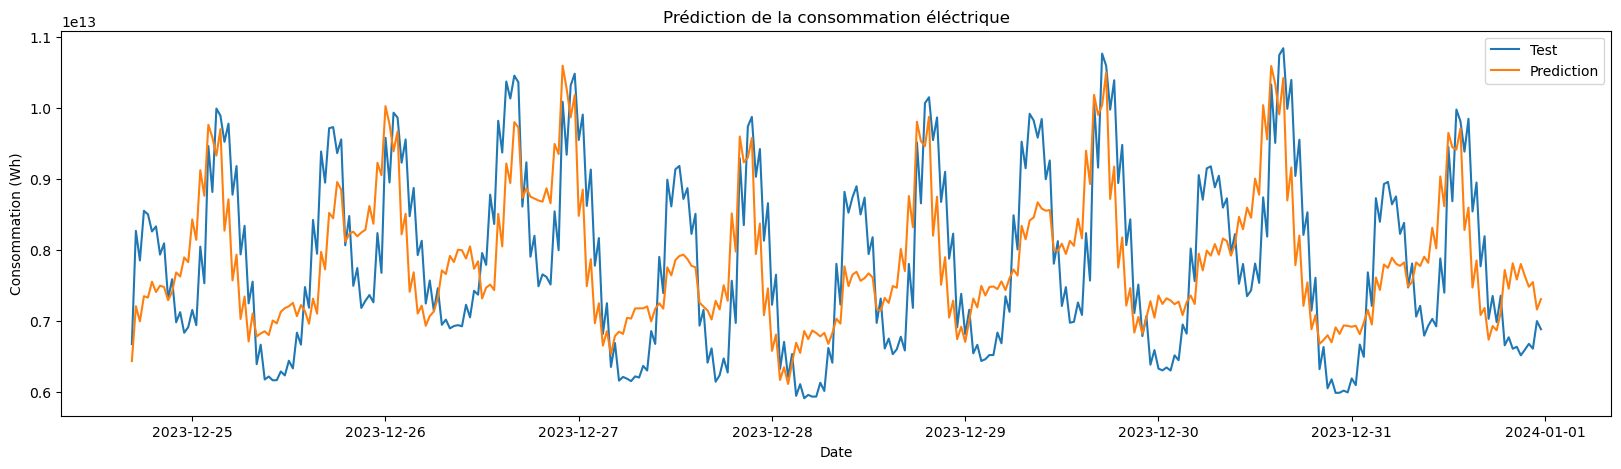

In [171]:
# Reconstitution
y_test = X_test['Total énergie soutirée (Wh)']*X_test['Nb points soutirage']
y_prediction = X_prediction_composant['tendance'] * X_prediction_composant['residuel']*X_test['Nb points soutirage']

for periode in periodes:
    y_prediction = y_prediction * X_prediction_composant[periode].values.flatten()

y_prediction = pd.Series(y_prediction, index = y_test.index)


plt.figure(figsize=(20,5))
plt.plot(y_test, label ='Test')
plt.plot(y_prediction, label ="Prediction")

plt.title(f"Prédiction de la consommation éléctrique")
plt.xlabel("Date")
plt.ylabel("Consommation (Wh)")
plt.legend()
#Erreur mape 
from sklearn.metrics import mean_squared_error
mape = mean_absolute_percentage_error(y_test, y_prediction)
mae = mean_absolute_error(y_test, y_prediction)
rmse = mean_squared_error(y_test, y_prediction)
print(f"MAPE: {mape:.2%}")
print(f"MAE: {mae:.2}")

print(f"RMSE: {np.sqrt(rmse):.2}")

In [ ]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
import pandas as pd
import os
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

reg = 0


# création d'un dossier pour stocker les résultats (scores)
folder_resultats = os.path.join(folder_projet_BD, "resultats") 

filename = "resultats_Auvergne-Rhône-Alpes.csv"
file_sortie = os.path.join(folder_resultats, filename)
df_res = pd.read_csv(file_sortie)
df_res.head(20)